# Load Data

In [1]:
import pickle

In [2]:
with open('/project_final/orbitals.pkl', 'rb') as f:
    orbitals = pickle.load(f)

with open('/project_final/maneuvers.pkl', 'rb') as f:
    maneuvers = pickle.load(f)

# Check day time uniform and interpolate

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

In [4]:
man = maneuvers['s3a']

In [5]:
data = orbitals['Sentinel-3A.csv'].copy()
data = data[['Brouwer mean motion']].copy()
data.rename(columns={"Brouwer mean motion": "mean_motion"}, inplace=True)

In [6]:
df = data.copy()

In [7]:
df.index = pd.to_datetime(df.index)

# keep only year-month-day
df.index = df.index.normalize()

# Split data and pre-process

In [8]:
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor

In [9]:
def make_lagged_features(series, num_lags=3, val_ratio=0.2):
    df_x = pd.DataFrame({f"lag_1": series})
    for lag in range(2, num_lags + 1):
        df_x[f"lag_{lag}"] = series.shift(lag)
    df_x = df_x.iloc[num_lags:].copy()
    df_y = series.iloc[num_lags:].copy()

    X_train, X_val, y_train, y_val = train_test_split(
        df_x, df_y, test_size=val_ratio, shuffle=False
    )
    return X_train, X_val, y_train, y_val

In [10]:
scaler = RobustScaler()
scaled_values = scaler.fit_transform(df['mean_motion'].values.reshape(-1,1)).flatten()
scaled_series = pd.Series(scaled_values, index=df.index, name='mean_motion_scaled')

# XGBoost Model Build and Tuning

In [11]:
param_dict = {
    'n_estimators': [50, 70, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.01],
    'reg_lambda':[0.1, 1, 10],
    'subsample':[0.3, 0.5, 1],
    'colsample_bytree':[0.3, 0.5, 1],
    'num_lag_features': [3, 5, 7, 11]
}

grid = list(ParameterGrid(param_dict))

In [12]:
results = []
models  = []

for params in grid:
    num_lags = params.pop('num_lag_features')
    
    X_train, X_val, y_train, y_val = make_lagged_features(series= scaled_series, num_lags=num_lags, val_ratio=0.2)
    
    model = XGBRegressor(
        **params,
        objective='reg:squarederror',
        eval_metric='mae',
        early_stopping_rounds=10,
        random_state=42
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        verbose=False
    )
    
    preds_val = model.predict(X_val)
    val_mae = mean_absolute_error(y_val, preds_val)
    
    results.append({
        **params,
        'num_lag_features': num_lags,
        'best_iteration': model.best_iteration if model.best_iteration is not None else -1,
        'val_mae': val_mae
    })
    
    models.append(model)

results_df = pd.DataFrame(results)

In [13]:
results_df.sort_values(by='val_mae', ascending=True).head()

,colsample_bytree,learning_rate,max_depth,n_estimators,reg_lambda,subsample,num_lag_features,best_iteration,val_mae
1046,1.0,0.1,5,100,0.1,1.0,3,90,0.016674
1045,1.0,0.1,5,100,0.1,0.5,3,66,0.016697
1009,1.0,0.1,5,70,0.1,0.5,3,66,0.016697
1044,1.0,0.1,5,100,0.1,0.3,3,86,0.016736
1010,1.0,0.1,5,70,0.1,1.0,3,69,0.016779


In [14]:
best_idx = results_df[results_df['val_mae'] > 0]['val_mae'].idxmin()
best_params_row = results_df.loc[best_idx]
best_num_lags = best_params_row['num_lag_features']

print(f"Best params at index {best_idx} with val MAE={best_params_row['val_mae']}")
print(best_params_row)

Best params at index 1046 with val MAE=0.016673614639553677
colsample_bytree      1.000000
learning_rate         0.100000
max_depth             5.000000
n_estimators        100.000000
reg_lambda            0.100000
subsample             1.000000
num_lag_features      3.000000
best_iteration       90.000000
val_mae               0.016674
Name: 1046, dtype: float64


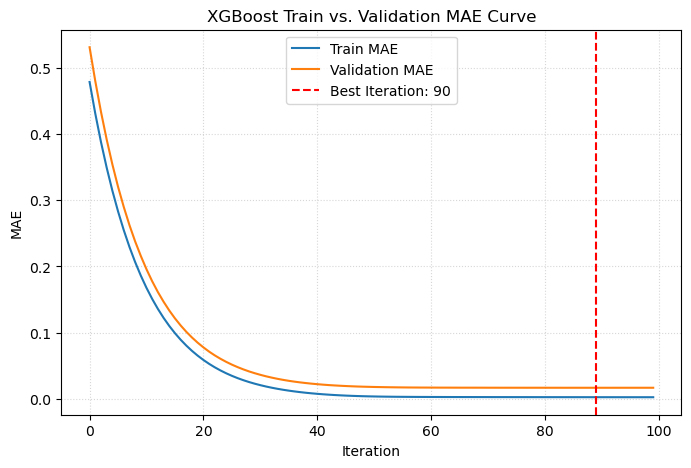

In [15]:
best_idx = results_df[results_df['val_mae'] > 0]['val_mae'].idxmin()
best_model = models[best_idx]

evals = best_model.evals_result()
train_mae = evals['validation_0']['mae']  
val_mae = evals['validation_1']['mae']  

iters = range(len(train_mae))

plt.figure(figsize=(8, 5))
plt.plot(iters, train_mae, label='Train MAE')
plt.plot(iters, val_mae, label='Validation MAE')

best_iter = best_model.best_iteration
if best_iter is not None:
    plt.axvline(
        x=best_iter - 1,
        color='red',
        linestyle='--',
        label=f'Best Iteration: {best_iter}'
    )

plt.xlabel('Iteration')
plt.ylabel('MAE')
plt.title('XGBoost Train vs. Validation MAE Curve')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.5)
plt.show()

# Fit with tuned XGB models

In [16]:
X_train, X_val, y_train, y_val = make_lagged_features(
    scaled_series, num_lags=int(best_num_lags), val_ratio=0.2
)

X_train_val = pd.concat([X_train, X_val]).sort_index()
y_train_val = pd.concat([y_train, y_val]).sort_index()

In [17]:
best_params = best_params_row.to_dict()
best_params.pop('val_mae')

best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['max_depth'] = int(best_params['max_depth'])
best_params['learning_rate'] = float(best_params['learning_rate'])
best_params['reg_lambda'] = float(best_params['reg_lambda'])

best_params

{'colsample_bytree': 1.0,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 100,
 'reg_lambda': 0.1,
 'subsample': 1.0,
 'num_lag_features': 3.0,
 'best_iteration': 90.0}

In [18]:
final_model = XGBRegressor(
    **best_params,
    objective='reg:squarederror',
    eval_metric='mae',
    random_state=42
)

In [19]:
final_model.fit(X_train_val, y_train_val)

c:\Users\liaomx\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:45:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "best_iteration", "num_lag_features" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBRegressor(base_score=None, best_iteration=90.0, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, ...)

In [20]:
final_model.get_booster().get_score(importance_type="weight")

{'lag_1': 1711.0, 'lag_2': 536.0, 'lag_3': 582.0}

In [21]:
pred_train_val = final_model.predict(X_train_val)

In [22]:
df_pred_train_val = pd.DataFrame({'prediction': pred_train_val}, index=y_train_val.index)
# df_pred_test = pd.DataFrame({'prediction': pred_test}, index=y_test.index)
df_pred_all = pd.concat([df_pred_train_val]).sort_index()

In [23]:
xgb_pred = pd.DataFrame({
    'actual': pd.concat([y_train_val]),
    'pred': df_pred_all['prediction']
})

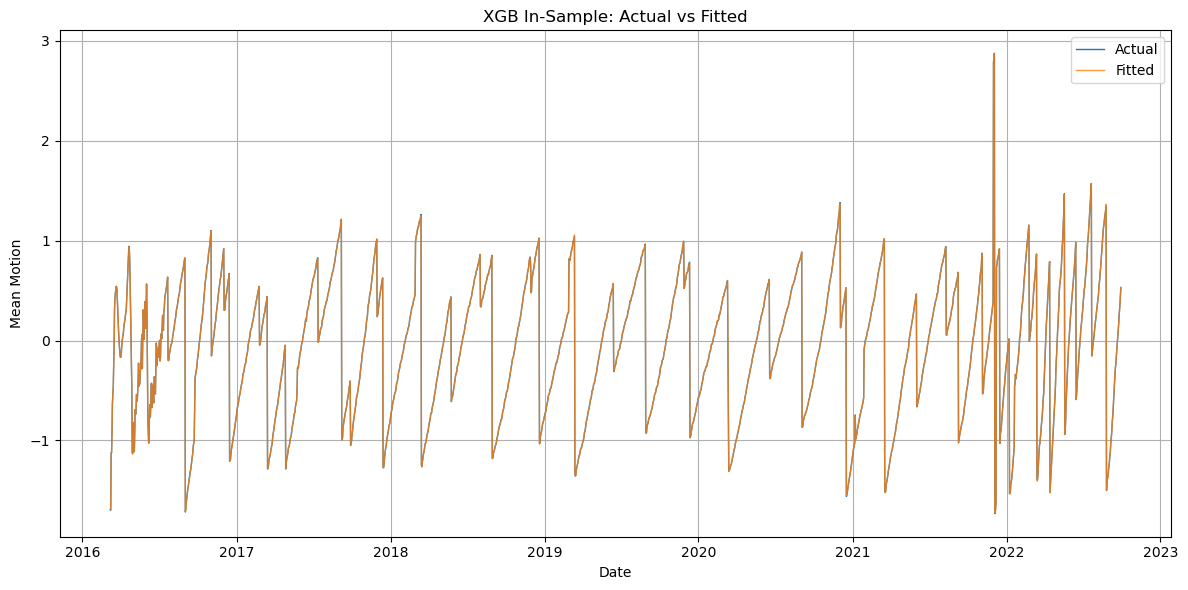

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(xgb_pred.index, xgb_pred["actual"], label="Actual", linewidth=1)
plt.plot(xgb_pred.index, xgb_pred["pred"], label="Fitted", linewidth=1, alpha=0.8)

plt.title("XGB In‑Sample: Actual vs Fitted")
plt.xlabel("Date")
plt.ylabel("Mean Motion")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Get XGB Residual from prediction vs true value

In [25]:
# xgb_pred['residual_orig'] = xgb_pred['actual_orig'] - xgb_pred['pred_orig']
xgb_pred['residual'] = xgb_pred['actual'] - xgb_pred['pred']

In [26]:
xgb_pred.to_csv("/project_final/result/s3a_xgb_residuals.csv", index=True)

# Check residuals - distribution and QQ

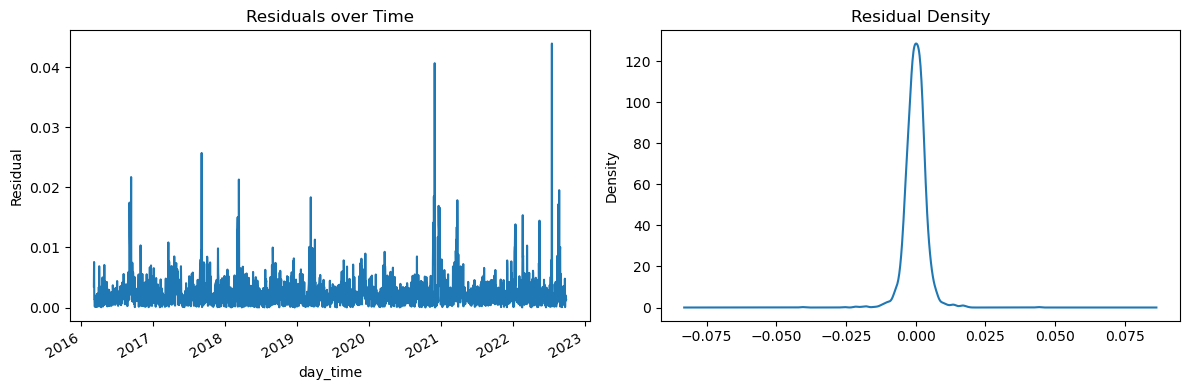

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

np.abs(xgb_pred['residual']).plot(ax=ax[0], title="Residuals over Time")
ax[0].set_ylabel("Residual")

xgb_pred['residual'].plot(kind='kde', ax=ax[1], title="Residual Density")

plt.tight_layout()
plt.show()

In [28]:
import scipy.stats as stats

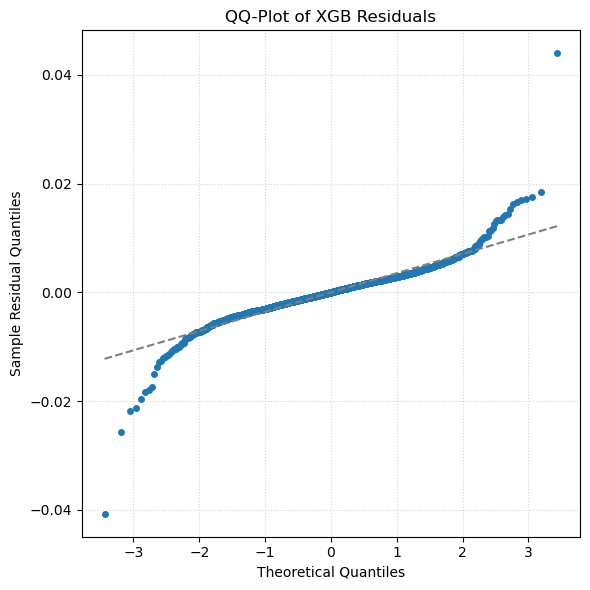

In [29]:
xgb_res = xgb_pred['residual']

# get qq plts for res
fig, ax = plt.subplots(figsize=(6,6))
stats.probplot(xgb_res, dist="norm", plot=ax)

dots, line = ax.get_lines()
dots.set_marker('o')
dots.set_markersize(4)
dots.set_color('tab:blue')

line.set_linestyle('--')
line.set_color('tab:gray')

ax.grid(True, linestyle=':', alpha=0.5)
ax.set_title("QQ-Plot of XGB Residuals")
ax.set_xlabel("Theoretical Quantiles")
ax.set_ylabel("Sample Residual Quantiles")

plt.tight_layout()
plt.show()

# Extract anomlies

In [30]:
import scipy.stats as sts

In [31]:
# get means and var for res
mu    = xgb_res.mean()
sigma = xgb_res.std()

In [32]:
# p_low, p_high = sts.norm.cdf([-2, +2.6])
# print("percentile range", p_low, p_high)

In [33]:
# low, high = xgb_res.quantile([p_low, p_high])
# # print("anomlies thresholds selected：", low, high)

# get anomalies
# anomalies = xgb_res[(xgb_res < low) | (xgb_res > high)]
anomalies = xgb_res[np.abs(xgb_res - mu) > 2 * sigma]
print("num of anomalies：", len(anomalies))

num of anomalies： 89


# Visulize result

In [34]:
manoeuvre_dates = pd.to_datetime(man['median_day_time']).dt.date
manoeuvre_dates = pd.to_datetime(manoeuvre_dates)
manoeuvre_dates = manoeuvre_dates[manoeuvre_dates.isin(df.index)]

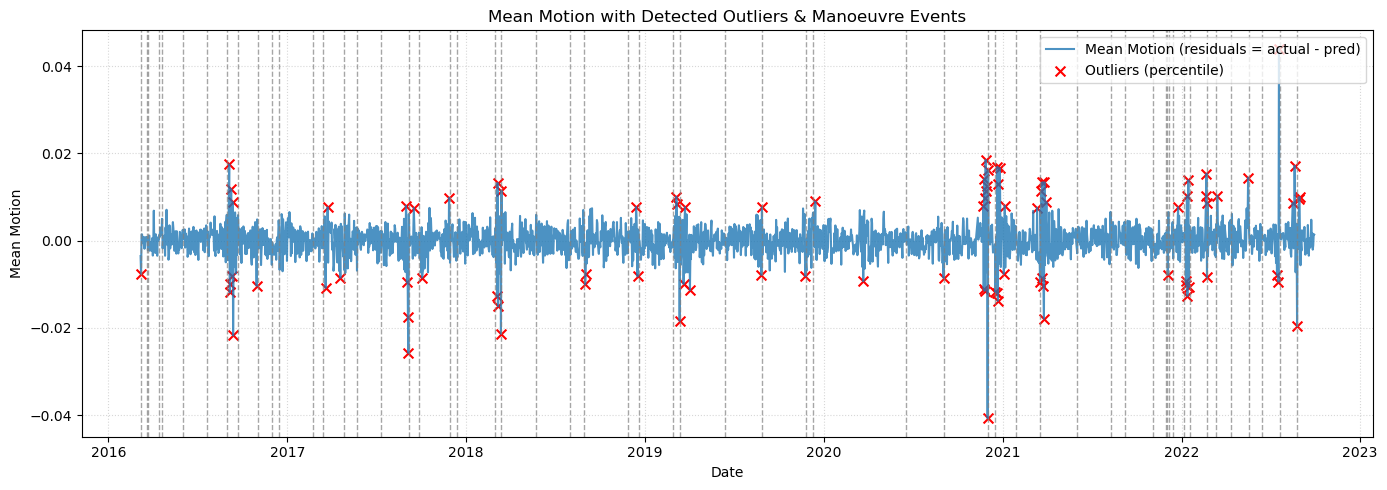

In [35]:
plt.figure(figsize=(14, 5))

# # 1) plt actual
# plt.plot(arima_pred.index, 
#          arima_pred['actual'], 
#          label='Mean Motion (actual)', 
#          color='C0', 
#          alpha=0.8)

# 1) plt -residuals
plt.plot(xgb_pred.index, 
         xgb_pred['residual'], 
         label='Mean Motion (residuals = actual - pred)', 
         color='C0', 
         alpha=0.8)

# 2) plt man
for dt in manoeuvre_dates:
    plt.axvline(x=dt,
                color='gray',
                linestyle='--',
                linewidth=1,
                alpha=0.7)
    
# 3) plt anomalies
plt.scatter(
    anomalies.index,
    xgb_pred.loc[anomalies.index, 'residual'],
    color='red',
    marker='x',
    s=50,
    label='Outliers (percentile)'
)

plt.title("Mean Motion with Detected Outliers & Manoeuvre Events")
plt.xlabel("Date")
plt.ylabel("Mean Motion")
plt.grid(True, linestyle=':', alpha=0.5)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

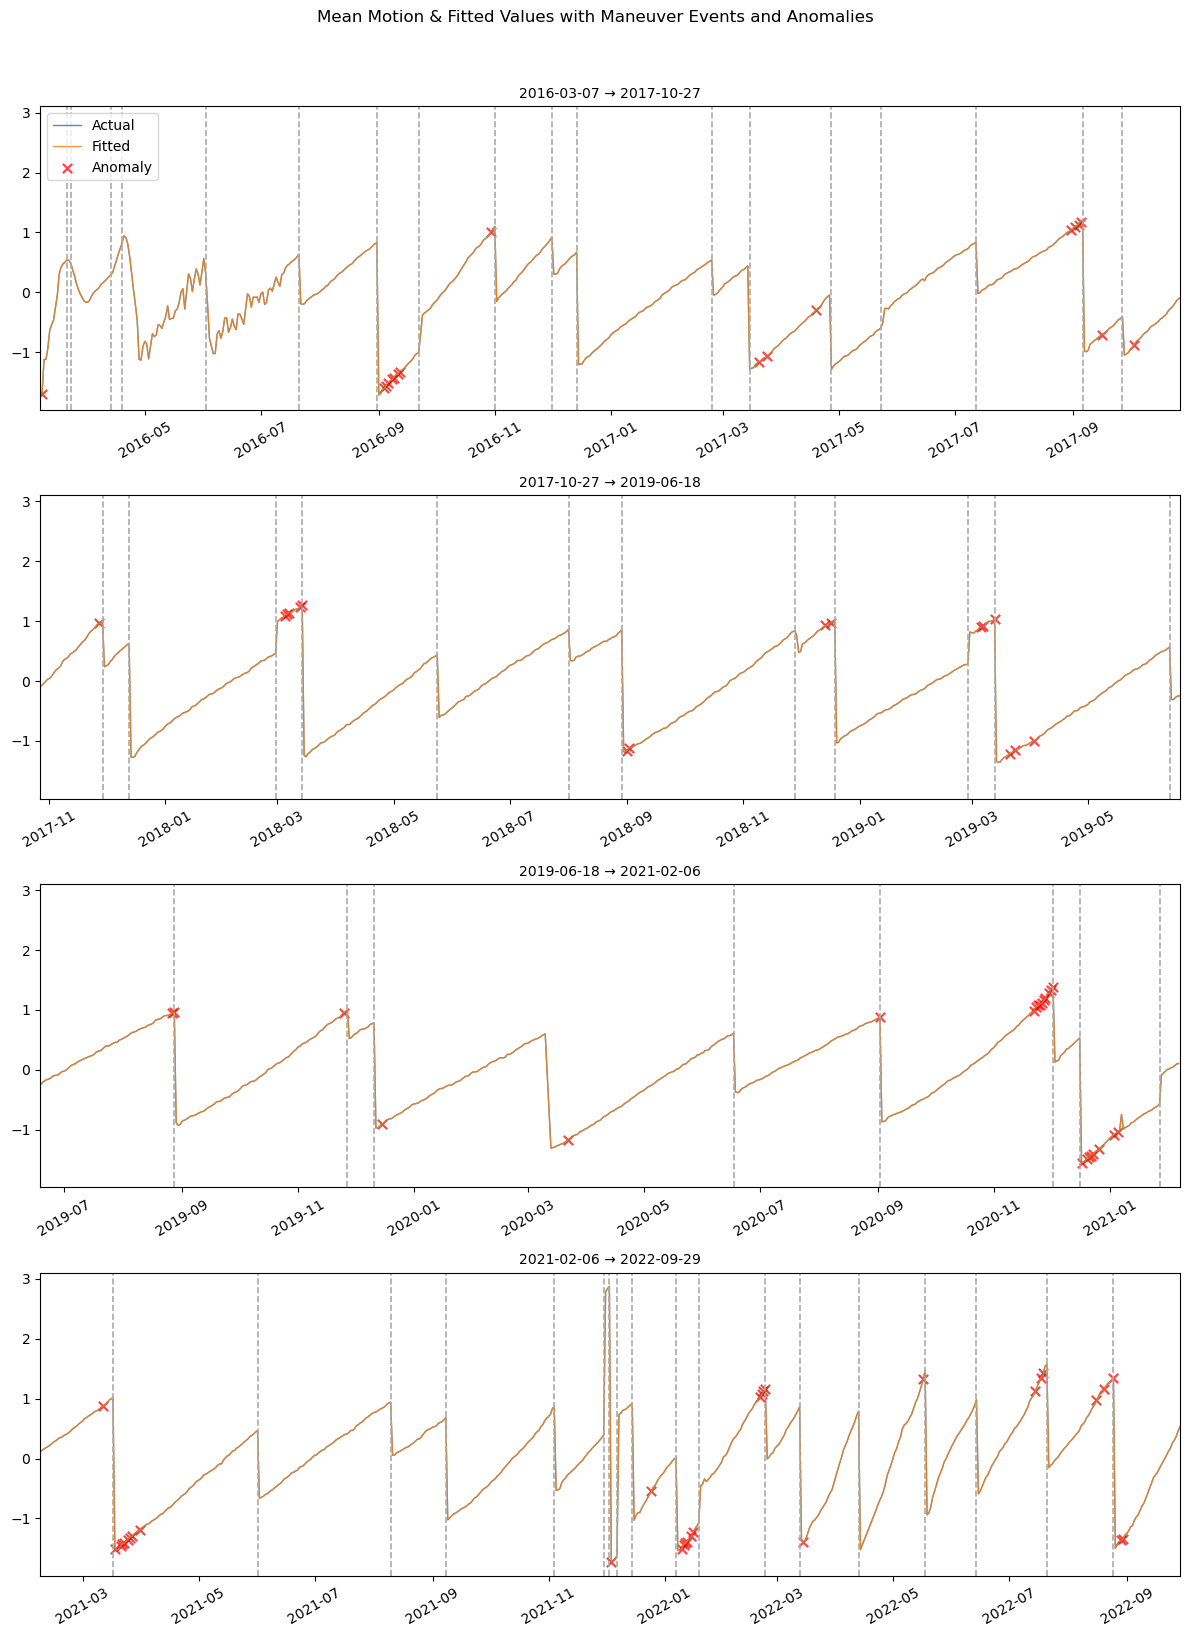

In [36]:
# get multi-cols plts
start, end = xgb_pred.index.min(), xgb_pred.index.max()
knots = pd.date_range(start, end, periods=5)
intervals = list(zip(knots[:-1], knots[1:]))

fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharey=True)

for ax, (seg_start, seg_end) in zip(axes, intervals):
    segment = xgb_pred.loc[seg_start:seg_end]
    
    # actual
    ax.plot(
        segment.index, segment['actual'],
        label='Actual', color='#1f77b4', alpha=0.8, linewidth=1.0
    )
    # plt fitted
    ax.plot(
        segment.index, segment['pred'],
        label='Fitted', color='#ff7f0e', alpha=0.8, linewidth=1.0
    )
    
    # # plt -residuals
    # plt.plot(arima_pred.index, 
	# 		arima_pred['residual'], 
	# 		label='Mean Motion (residuals = actual - pred)', 
	# 		color='C0', 
	# 		alpha=0.8)
    
    # 3) plt anomalies
    idx1 = anomalies.loc[seg_start:seg_end].index
    ax.scatter(
        idx1,
        segment.loc[idx1, 'actual'],
        color='red', 
        marker='x',
        alpha = 0.75,
        s=45,
        label='Anomaly'
    )
    
    # 4) plt man
    for dt in manoeuvre_dates:
        if seg_start <= dt <= seg_end:
            ax.axvline(
                x=dt, color='#aaaaaa',
                linestyle='--', linewidth=1.2, alpha=1.0
            )
    
    # tight layout
    ax.set_xlim(seg_start, seg_end)
    # ax.grid(True, linestyle=':', alpha=0.5)
    ax.set_title(f"{seg_start.date()} → {seg_end.date()}", fontsize=10)
    ax.tick_params(axis='x', rotation=30)
    
    if ax is axes[0]:
        ax.legend(loc='upper left')

fig.suptitle(
    "Mean Motion & Fitted Values with Maneuver Events and Anomalies",
    y=1.02, fontsize=12
)
plt.tight_layout()
plt.show()

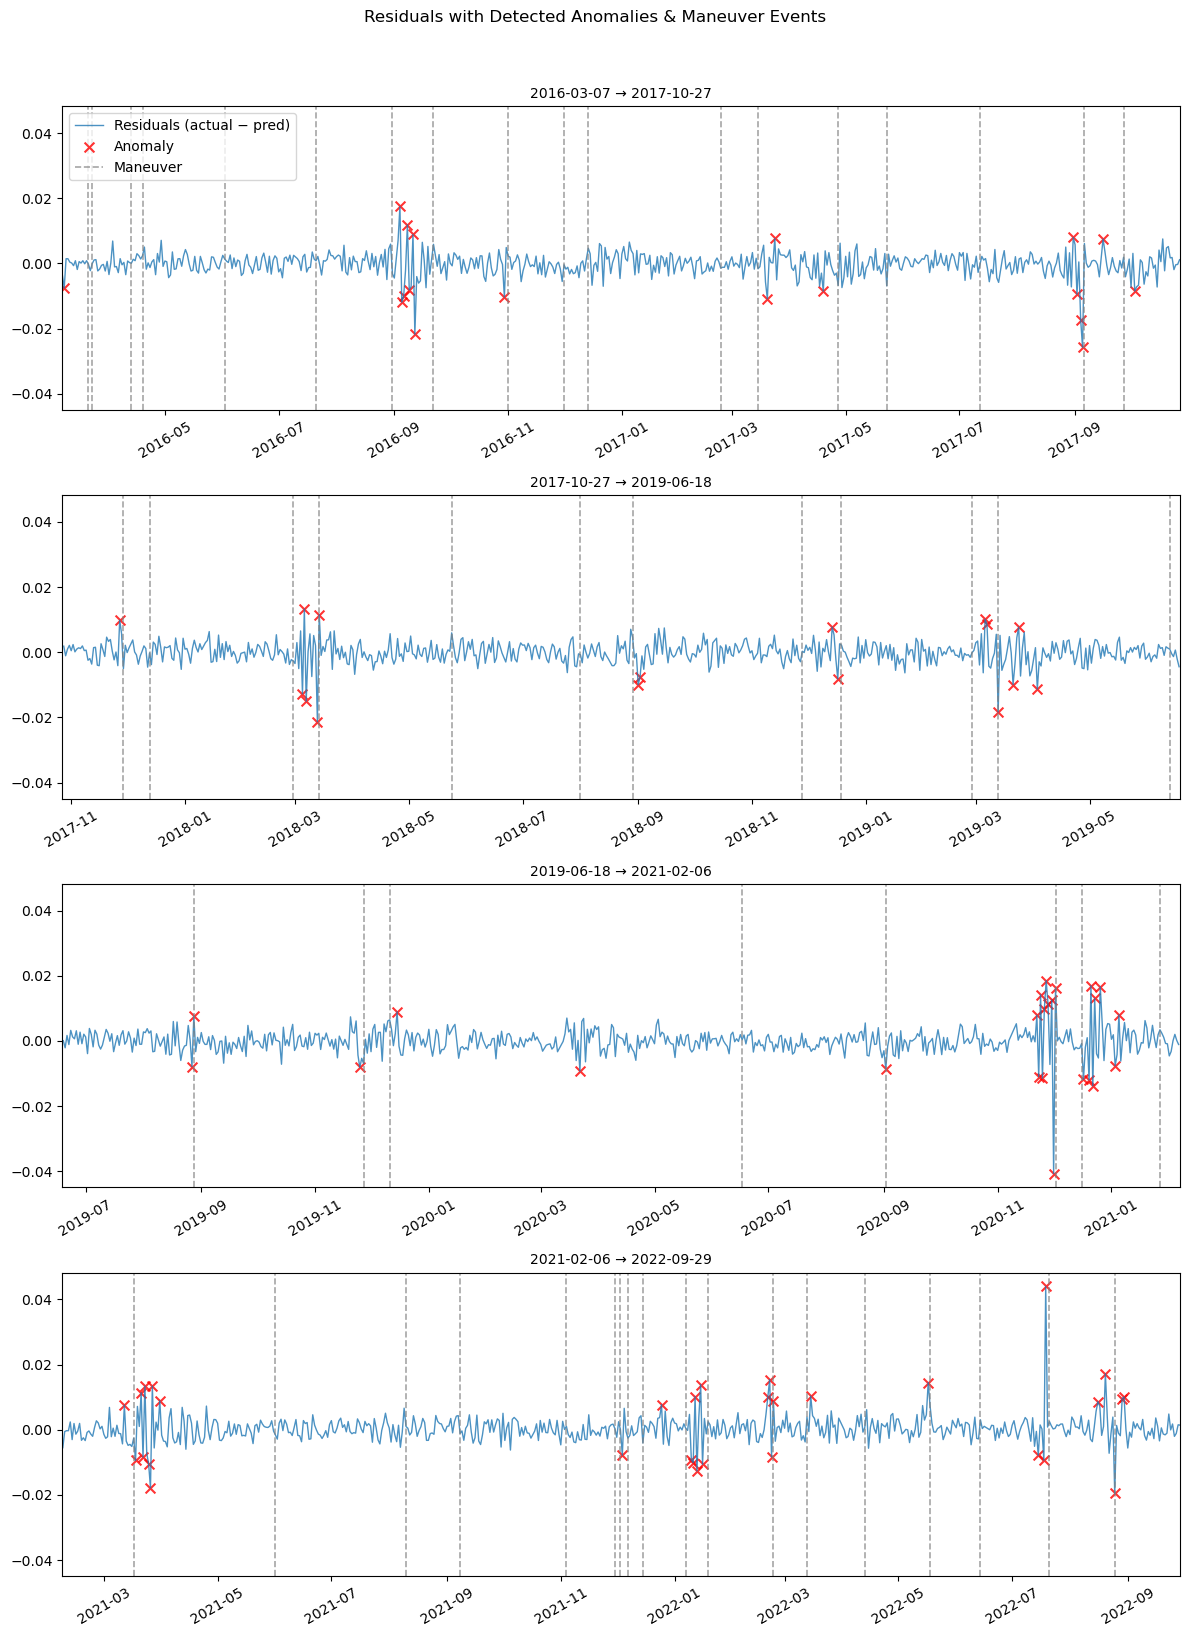

In [37]:
# residuals

fig, axes = plt.subplots(4, 1, figsize=(12, 16), sharey=True)

for ax, (seg_start, seg_end) in zip(axes, intervals):
    segment = xgb_pred.loc[seg_start:seg_end]
    
    ax.plot(
        segment.index, segment['residual'],
        label='Residuals (actual − pred)',
        color='C0', alpha=0.8, linewidth=1.0
    )

    idx1 = anomalies.loc[seg_start:seg_end].index
    ax.scatter(
        idx1, segment.loc[idx1, 'residual'],
        color='red', marker='x', s=50, alpha=0.8,
        label='Anomaly'
    )
    
    first = True
    for dt in manoeuvre_dates:
        if seg_start <= dt <= seg_end:
            ax.axvline(
                x=dt, color='gray', linestyle='--',
                linewidth=1.2, alpha=0.7,
                label='Maneuver' if first else None
            )
            first = False
    
    ax.set_xlim(seg_start, seg_end)
    ax.set_title(f"{seg_start.date()} → {seg_end.date()}", fontsize=10)
    ax.tick_params(axis='x', rotation=30)
    if ax is axes[0]:
        ax.legend(loc='upper left')

fig.suptitle(
    "Residuals with Detected Anomalies & Maneuver Events",
    y=1.02, fontsize=12
)
plt.tight_layout()
plt.show()

# Record num of man and anomlies

In [38]:
# records num of anomlies and man
man_df   = man.copy()             # man
anom_idx = anomalies.index        # outliers index

man_days  = pd.to_datetime(man_df['median_day_time']).dt.normalize()
anom_days = anom_idx.normalize()

anom_set = set(anom_days)

# check deteced in +- n days range
n = 3 

matched_manoeuvres = []
unmatched_manoeuvres = []

for d in man_days:
    window = set(d + pd.to_timedelta(offset, unit='D') for offset in range(-n, n+1))
    
    if window & anom_set:
        matched_manoeuvres.append(d)
    else:
        unmatched_manoeuvres.append(d)

summary = pd.DataFrame({
    "category": [
        "total_manoeuvres",
        "total_anomalies",
        f"manoeuvres_matched_within_±{n}d",
        f"manoeuvres_unmatched_within_±{n}d"
    ],
    "count": [
        len(man_days),
        len(anom_days),
        len(matched_manoeuvres),
        len(unmatched_manoeuvres)
    ]
})

summary

,category,count
0,total_manoeuvres,64
1,total_anomalies,89
2,manoeuvres_matched_within_±3d,23
3,manoeuvres_unmatched_within_±3d,41


In [39]:
# summary.to_csv("result\s3a_xgb_result.csv", index=False)